In [2]:
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from imutils import contours
import argparse
import imutils
import cv2
from sklearn.cluster import KMeans, DBSCAN
import random as rng
import os
import shutil

## Version 1

In [269]:
def preprocess(img):

    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV_FULL)

    img = cv2.GaussianBlur(img, (11, 11), 0)
    # img = cv2.medianBlur(img,  11)
    
    img = img/255

    return img

In [4]:
def plotImage(img, title):
    
    plt.imshow(img)
    #plt.title('Clustered Image')
    plt.savefig('results/v1/'+title)
    plt.show()

In [5]:
def white_balance_loops(img):
    result = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    avg_a = np.average(result[:, :, 1])
    avg_b = np.average(result[:, :, 2])
    for x in range(result.shape[0]):
        for y in range(result.shape[1]):
            l, a, b = result[x, y, :]
            # fix for CV correction
            l *= 100 / 255.0
            result[x, y, 1] = a - ((avg_a - 128) * (l / 100.0) * 1.1)
            result[x, y, 2] = b - ((avg_b - 128) * (l / 100.0) * 1.1)
    result = cv2.cvtColor(result, cv2.COLOR_LAB2BGR)
    return result

In [6]:
def shadow_remove(img):
    rgb_planes = cv2.split(img)
    result_norm_planes = []
    for plane in rgb_planes:
        dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
        bg_img = cv2.medianBlur(dilated_img, 21)
        diff_img = 255 - cv2.absdiff(plane, bg_img)
        norm_img = cv2.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        result_norm_planes.append(norm_img)
    shadowremov = cv2.merge(result_norm_planes)
    return shadowremov

In [7]:
def cropOrig(bRect, oimg):
    # x (Horizontal), y (Vertical Downwards) are start coordinates
    # img.shape[0] = height of image
    # img.shape[1] = width of image

    x,y,w,h = bRect

    print(x,y,w,h)
    pcropedImg = oimg[y:y+h,x:x+w]

    x1, y1, w1, h1 = 0, 0, pcropedImg.shape[1], pcropedImg.shape[0]

    y2 = int(h1/10)

    x2 = int(w1/10)

    crop1 = pcropedImg[y1+y2:h1-y2,x1+x2:w1-x2]

    #cv2_imshow(crop1)

    ix, iy, iw, ih = x+x2, y+y2, crop1.shape[1], crop1.shape[0]

    croppedImg = oimg[iy:iy+ih,ix:ix+iw]

    return croppedImg, pcropedImg

In [70]:
def kMeans_cluster(img):

    # For clustering the image using k-means, we first need to convert it into a 2-dimensional array
    # (H*W, N) N is channel = 3
    image_2D = img.reshape(img.shape[0]*img.shape[1], img.shape[2])

    # tweak the cluster size and see what happens to the Output
    kmeans = KMeans(n_clusters=3, random_state=0).fit(image_2D)
    clustOut = kmeans.cluster_centers_[kmeans.labels_]

    # Reshape back the image from 2D to 3D image
    clustered_3D = clustOut.reshape(img.shape[0], img.shape[1], img.shape[2])

    clusteredImg = np.uint8(clustered_3D*255)
    clusteredImg = cv2.medianBlur(clusteredImg, 21)
    return clusteredImg

In [9]:
def gammaCorrection(src, gamma):
    invGamma = 1 / gamma

    table = [((i / 255) ** invGamma) * 255 for i in range(256)]
    table = np.array(table, np.uint8)

    return cv2.LUT(src, table)

In [10]:
def paperEdgeDetection(clusteredImage):
  edged1 = cv2.Canny(clusteredImage, 0, 255, 15)
  edged = cv2.dilate(edged1, kernel=(5, 5), iterations=10)
  edged = cv2.erode(edged, kernel=(5, 5), iterations=8)
  
  edged = cv2.fastNlMeansDenoising(edged, None, 20, 7, 21) 
  # edged = cv2.medianBlur(edged, 3)
  return edged

In [201]:
def overlayImage(croppedImg, pcropedImg):
    x1, y1, w1, h1 = 0, 0, pcropedImg.shape[1], pcropedImg.shape[0]

    y2 = int(h1/10)

    x2 = int(w1/10)

    new_image = np.zeros((pcropedImg.shape[0], pcropedImg.shape[1], 3), np.uint8)
    new_image[:, 0:pcropedImg.shape[1]] = (117, 13, 205) # (B, G, R)
    
    new_image[ y1+y2:y1+y2+croppedImg.shape[0], x1+x2:x1+x2+croppedImg.shape[1]] = croppedImg
    new_image[np.where((new_image==[246,57,178]).all(axis=2))] = [117, 13, 205]
    new_image[np.where((new_image==[57,6,180]).all(axis=2))] = [117, 13, 205]
    new_img = cv2.medianBlur(new_image, 17)
    
    return new_image

In [12]:
def footEdgeDetection(clusteredImage):
  edged1 = cv2.Canny(clusteredImage, 0, 255)
  edged = cv2.dilate(edged1, kernel=(5, 5), iterations=10)
  edged = cv2.erode(edged, kernel=(5, 5), iterations=9)
  
  # edged = cv2.fastNlMeansDenoising(edged, None, 20, 7, 21) 
  return edged

In [13]:
def getBoundingBox(img):

    contours, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    #print(len(contours))
    contours = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)
    
    

    contours_poly = [None]*len(contours)
    boundRect = [None]*len(contours)

    for i, c in enumerate(contours):
        contours_poly[i] = cv2.approxPolyDP(c, 3, True)
        boundRect[i] = cv2.boundingRect(contours_poly[i])

    
    return boundRect, contours, contours_poly, img

In [14]:
def drawCnt(bRect, contours, cntPoly, img):

    drawing = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)   


    paperbb = bRect

    for i in range(len(contours)):
      color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
      cv2.drawContours(drawing, cntPoly, i, color)
      #cv2.rectangle(drawing, (int(boundRect[i][0]), int(boundRect[i][1])), \
              #(int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])), color, 2)
    cv2.rectangle(drawing, (int(paperbb[0]), int(paperbb[1])), \
              (int(paperbb[0]+paperbb[2]), int(paperbb[1]+paperbb[3])), color, 2)
    
    return drawing

In [293]:
img_path = 'images/24071.jpeg'
oimg = imread(img_path)
if os.path.exists('results/v1/' + img_path.split('/')[-1].split('.')[0]):
    shutil.rmtree('results/v1/' + img_path.split('/')[-1].split('.')[0])
os.mkdir('results/v1/' + img_path.split('/')[-1].split('.')[0])

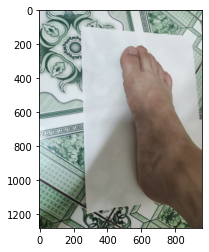

In [275]:
gamma_img = gammaCorrection(oimg, 1)
plt.imshow(gamma_img)

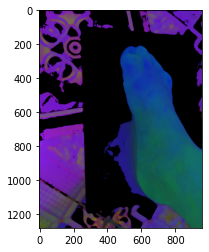

In [276]:
gamma_img = cv2.medianBlur(gamma_img, 21)
hsv = cv2.cvtColor(gamma_img, cv2.COLOR_RGB2HSV_FULL)
# for skin
# lower = np.array([27, 0, 0])
# upper = np.array([155, 255, 255])

# for paper
lower = np.array([0, 23, 0])
upper = np.array([179, 255, 255])
mask = cv2.inRange(hsv, lower, upper)
result = cv2.bitwise_and(gamma_img, gamma_img, mask=mask)

plt.imshow(cv2.cvtColor(result, cv2.COLOR_RGB2HSV_FULL))

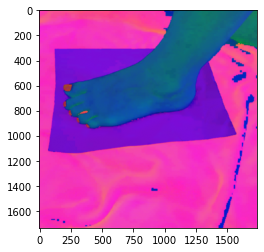

In [294]:
preprocessedOimg = preprocess(oimg)
plotImage(preprocessedOimg, img_path.split('/')[-1].split('.')[0]+'/preprocessed.jpg')

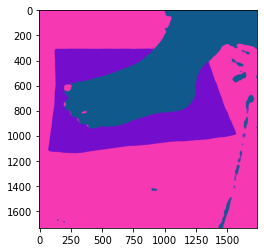

In [295]:
clusteredImg = kMeans_cluster(preprocessedOimg)
plotImage(clusteredImg, img_path.split('/')[-1].split('.')[0]+'/clustered.jpg')

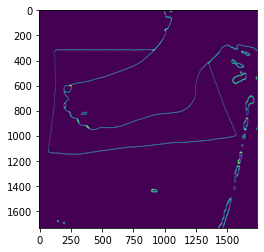

In [296]:
paperedgedImg = paperEdgeDetection(clusteredImg)
plotImage(paperedgedImg, img_path.split('/')[-1].split('.')[0]+'/edged.jpg')

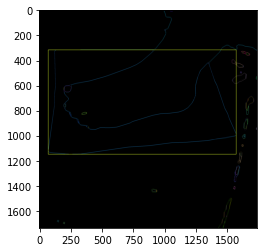

In [297]:
boundRect, contours, contours_poly, img = getBoundingBox(paperedgedImg)
pdraw = drawCnt(boundRect[1], contours, contours_poly, img)
plotImage(pdraw, img_path.split('/')[-1].split('.')[0]+'/boundingBox.jpg')

408 216 549 1064


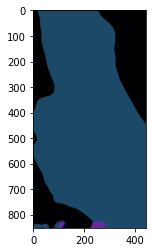

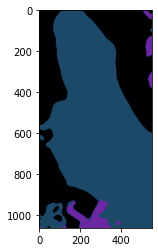

In [287]:
croppedImg, pcropedImg = cropOrig(boundRect[1], clusteredImg)
plotImage(croppedImg, img_path.split('/')[-1].split('.')[0]+'/cropped.jpg')
plotImage(pcropedImg, img_path.split('/')[-1].split('.')[0]+'/pcropped.jpg')

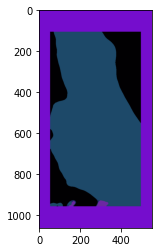

In [288]:
newImg = overlayImage(croppedImg, pcropedImg)
plotImage(newImg, img_path.split('/')[-1].split('.')[0]+'/overlayed.jpg')

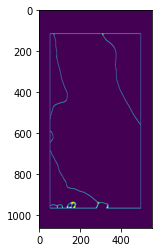

In [289]:
fedged = footEdgeDetection(newImg)
plotImage(fedged, img_path.split('/')[-1].split('.')[0]+'/fedged.jpg')

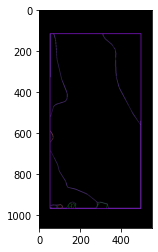

In [290]:
fboundRect, fcnt, fcntpoly, fimg = getBoundingBox(fedged)
fdraw = drawCnt(fboundRect[1], fcnt, fcntpoly, fimg)
plotImage(fdraw, img_path.split('/')[-1].split('.')[0]+'/fboundingBox.jpg')

In [291]:
def calcFeetSize(pcropedImg, fboundRect):
  x1, y1, w1, h1 = 0, 0, pcropedImg.shape[1], pcropedImg.shape[0]

  y2 = int(h1/10)

  x2 = int(w1/10)

  fh = y2 + fboundRect[1][3]
  fw = x2 + fboundRect[1][2]
  ph = pcropedImg.shape[0]
  pw = pcropedImg.shape[1]

  print("Feet height: ", fh)
  print("Feet Width: ", fw)

  print("Paper height: ", ph)
  print("Paper Width: ", pw)

  opw = 210
  oph = 297

  ofs = 0.0

  if fw>fh:
    ofs = (oph/pw)*fw
  else :
    ofs = (oph/ph)*fh



  return ofs

In [292]:
print("feet size (cm): ", calcFeetSize(pcropedImg, fboundRect)/10)
# Save result to txt file
with open('results/v1/' + img_path.split('/')[-1].split('.')[0] + '/result.txt', 'w') as f:
  f.write("Feet size (cm): " + str(calcFeetSize(pcropedImg, fboundRect)/10))

Feet height:  959
Feet Width:  496
Paper height:  1064
Paper Width:  549
feet size (cm):  26.76907894736842
Feet height:  959
Feet Width:  496
Paper height:  1064
Paper Width:  549


## Version 2

In [107]:
img_path = 'images/24072.jpeg'
oimg = imread(img_path)
# os.mkdir('results/v1/' + img_path.split('/')[-1].split('.')[0])

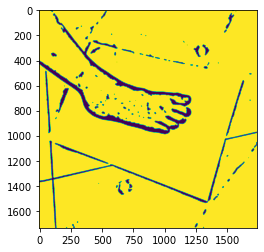

In [108]:
img = cv2.cvtColor(oimg, cv2.COLOR_RGB2GRAY)

# Bilateral filter preserv edges
img = cv2.bilateralFilter(img, 9, 75, 75)

# Create black and white image based on adaptive threshold
img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 115, 4)

# Median filter clears small details
img = cv2.medianBlur(img, 11)

# Add black border in case that page is touching an image border
# img = cv2.copyMakeBorder(img, 5, 5, 5, 5, cv2.BORDER_CONSTANT, value=[0, 0, 0])

plt.imshow(img)

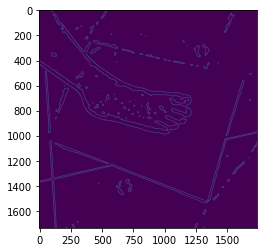

In [109]:
edges = cv2.Canny(img, 200, 250)
plt.imshow(edges)

In [113]:
contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Finding contour of biggest rectangle
# Otherwise return corners of original image
# Don't forget on our 5px border!
height = edges.shape[0]
width = edges.shape[1]
MAX_COUNTOUR_AREA = (width - 10) * (height - 10)

# Page fill at least half of image, then saving max area found
maxAreaFound = MAX_COUNTOUR_AREA * 0.5

# Saving page contour
pageContour = np.array([[5, 5], [5, height-5], [width-5, height-5], [width-5, 5]])

# Go through all contours
for cnt in contours:
    # Simplify contour
    perimeter = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, 0.03 * perimeter, True)

    # Page has 4 corners and it is convex
    # Page area must be bigger than maxAreaFound 
    if (len(approx) == 4 and
            cv2.isContourConvex(approx) and
            maxAreaFound < cv2.contourArea(approx) < MAX_COUNTOUR_AREA):

        maxAreaFound = cv2.contourArea(approx)
        pageContour = approx

In [115]:
pageContour

array([[   5,    5],
       [   5, 1731],
       [1731, 1731],
       [1731,    5]])

In [114]:
def fourCornersSort(pts):
    """ Sort corners: top-left, bot-left, bot-right, top-right """
    # Difference and sum of x and y value
    # Inspired by http://www.pyimagesearch.com
    diff = np.diff(pts, axis=1)
    summ = pts.sum(axis=1)
    
    # Top-left point has smallest sum...
    # np.argmin() returns INDEX of min
    return np.array([pts[np.argmin(summ)],
                     pts[np.argmax(diff)],
                     pts[np.argmax(summ)],
                     pts[np.argmin(diff)]])


def contourOffset(cnt, offset):
    """ Offset contour, by 5px border """
    # Matrix addition
    cnt += offset
    
    # if value < 0 => replace it by 0
    cnt[cnt < 0] = 0
    return cnt


# Sort and offset corners
pageContour = fourCornersSort(pageContour[:, 0])
pageContour = contourOffset(pageContour, (-5, -5))

# Recalculate to original scale - start Points
sPoints = pageContour.dot(image.shape[0] / 800)
  
# Using Euclidean distance
# Calculate maximum height (maximal length of vertical edges) and width
height = max(np.linalg.norm(sPoints[0] - sPoints[1]),
             np.linalg.norm(sPoints[2] - sPoints[3]))
width = max(np.linalg.norm(sPoints[1] - sPoints[2]),
             np.linalg.norm(sPoints[3] - sPoints[0]))

# Create target points
tPoints = np.array([[0, 0],
                    [0, height],
                    [width, height],
                    [width, 0]], np.float32)

# getPerspectiveTransform() needs float32
if sPoints.dtype != np.float32:
    sPoints = sPoints.astype(np.float32)

# Wraping perspective
M = cv2.getPerspectiveTransform(sPoints, tPoints) 
newImage = cv2.warpPerspective(image, M, (int(width), int(height)))

AxisError: axis 1 is out of bounds for array of dimension 1

(0.0, 256.0)

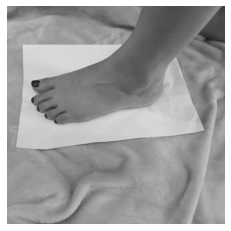

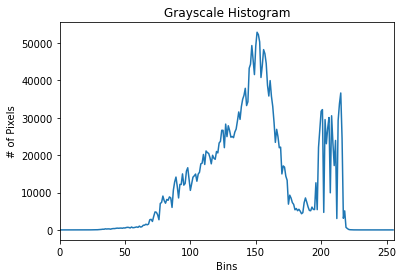

In [30]:
# check histogram of the image
gray = cv2.cvtColor(oimg, cv2.COLOR_BGR2GRAY)
hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
plt.figure()
plt.axis("off")
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB))
# plot the histogram
plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
plt.plot(hist)
plt.xlim([0, 256])

In [130]:
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

In [131]:
knn = KNeighborsClassifier(n_neighbors=7)

In [132]:
n_samples = len(os.listdir('images/'))
n_samples

241

In [151]:
dict_label = {0: 'normal_img',
              1: 'white_background_img',
              2: 'skin_background_img',
              3: 'pattern_background_img',
              4: 'curve_background_img'}
X = []
y = []
for folder in os.listdir('image_classified'):
    for img_path in os.listdir('image_classified/' + folder):
        img = cv2.imread('image_classified/' + folder + '/' + img_path)
        img = cv2.resize(img, (128, 128))
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # resize img to (128, 128)
        img = img/255
        # print(img.shape)
              
        # flatten img to 1D array
        img = img.flatten()
        X.append(img)
        y.append(dict_label[folder])
        
        

In [ ]:
dict_label = {'normal_img': 0,
              'white_background_img': 1,
              'skin_background_img': 2,
              'pattern_background_img': 3,
              'curve_background_img': 4}
X = []
y = []
for folder in os.listdir('image_classified'):
    for img_path in os.listdir('image_classified/' + folder):
        img = cv2.imread('image_classified/' + folder + '/' + img_path)
        img = cv2.resize(img, (128, 128))
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # resize img to (128, 128)
        img = img/255
        # print(img.shape)
              
        # flatten img to 1D array
        img = img.flatten()
        X.append(img)
        y.append(dict_label[folder])
        
        

In [152]:
X

[array([0.53333333, 0.53333333, 0.65098039, ..., 0.50196078, 0.49411765,
        0.63529412]),
 array([0.20784314, 0.29019608, 0.41568627, ..., 0.61568627, 0.58431373,
        0.72941176]),
 array([0.71764706, 0.72156863, 0.8       , ..., 0.49019608, 0.4745098 ,
        0.61568627]),
 array([0.56078431, 0.52156863, 0.69411765, ..., 0.59215686, 0.57254902,
        0.72156863]),
 array([0.74509804, 0.72156863, 0.84313725, ..., 0.60392157, 0.58039216,
        0.70196078]),
 array([0.15294118, 0.19215686, 0.30980392, ..., 0.14901961, 0.16078431,
        0.18039216]),
 array([0.21568627, 0.2745098 , 0.29019608, ..., 0.41176471, 0.42745098,
        0.43137255]),
 array([0.23137255, 0.31764706, 0.36470588, ..., 0.55686275, 0.58431373,
        0.56470588]),
 array([0.16078431, 0.20784314, 0.25882353, ..., 0.37647059, 0.39215686,
        0.39607843]),
 array([0.22352941, 0.30196078, 0.3254902 , ..., 0.18431373, 0.22352941,
        0.24705882]),
 array([0.45098039, 0.4745098 , 0.50980392, ..., 0

In [153]:
from sklearn import datasets, svm, metrics

In [154]:
clf = svm.SVC(gamma=0.001, C=100)
clf.fit(X, y)

SVC(C=100, gamma=0.001)

In [158]:
test_img = cv2.imread('images/test_1.jpg')
test_img = cv2.resize(test_img, (128, 128))
# test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
# resize test_img to (128, 128)
test_img = test_img/255
# print(test_img.shape)
        
# flatten test_img to 1D array
test_img = test_img.flatten()

predict = clf.predict([test_img])
predict

array([3])

array([2])